<a href="https://colab.research.google.com/github/m-evdokimov/dls-detector/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('i am here')

i am here


### Importing datasets to colab

Dataset: [WIDER face](http://shuoyang1213.me/WIDERFACE/)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#images
!unzip -q /content/drive/MyDrive/WIDER_train.zip -d train
!unzip -q /content/drive/MyDrive/WIDER_val.zip -d val
!unzip -q /content/drive/MyDrive/WIDER_test.zip -d test

In [3]:
#bounding boxes
!wget -P /content/ http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
!unzip -q /content/wider_face_split.zip -d face_split

--2021-01-11 10:48:54--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘/content/wider_face_split.zip’

wider_face_split.zi 100%[===================>]   3.42M  2.01MB/s    in 1.7s    

2021-01-11 10:48:57 (2.01 MB/s) - ‘/content/wider_face_split.zip’ saved [3591642/3591642]



In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

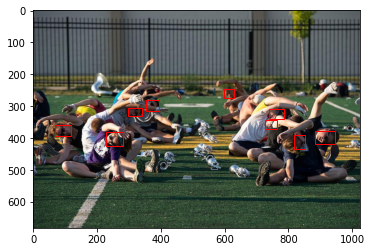

In [5]:
#visualizing an example
example_path = '/content/train/WIDER_train/images/0--Parade/0_Parade_marchingband_1_117.jpg'
bb_file_path = '/content/face_split/wider_face_split/wider_face_train_bbx_gt.txt'

with open(bb_file_path) as bb:
  counter = 0
  for line in bb:
    counter += 1
    line = line.strip()
    if line == '0--Parade/0_Parade_marchingband_1_117.jpg':
      line_index = counter
      break
  
  bbox_num = bb.readline().strip()
  bbox_list = []
  for _ in range(int(bbox_num)):
    bbox = bb.readline().strip().split()
    bbox_list.append(bbox)

fig = plt.figure()
ax = plt.axes()

for bbox in bbox_list:
  l, t, w, h, *scores = map(float, bbox)
  x, y, w, h = l, t, w, h
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='red', facecolor='none')
  ax.add_patch(rect)


img = mpimg.imread(example_path)
ax.imshow(img)
plt.show()


In [7]:
import torch
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [8]:
torch.hub.list('NVIDIA/DeepLearningExamples:torchhub')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


['checkpoint_from_distributed',
 'nvidia_ncf',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_waveglow',
 'unwrap_distributed']

In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

In [ ]:
ssd_model.to('cuda')
ssd_model.eval()

In [ ]:
#for reading code
!cat /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/hubconf.py

In [32]:
import numpy as np
input = [utils.prepare_input(example_path)]
tensor = utils.prepare_tensor(input, precision == 'fp16')


with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [40]:
results_per_input = utils.decode_results(detections_batch)

In [48]:
best_results_per_input = [utils.pick_best(results, 0.35) for results in results_per_input]
classes_to_labels = utils.get_coco_object_dictionary()

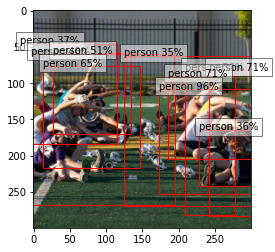

In [49]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = input[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

As we see in the picture above, detector found some persons